<a href="https://colab.research.google.com/github/spaceBearAmadeus/Student_Need_Navigator_SCRATCH/blob/master/Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#raw data in the form of .krn files
!unzip /content/deutschl.zip

!pip install music21
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!pip install pygame

Streaming output truncated to the last 5000 lines.
  inflating: essen/europa/deutschl/zuccal/deut4795.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4234.krn  
  inflating: essen/europa/deutschl/zuccal/deut4521.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4136.krn  
  inflating: essen/europa/deutschl/zuccal/deut4922.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4294.krn  
  inflating: essen/europa/deutschl/zuccal/deut4613.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4255.krn  
  inflating: essen/europa/deutschl/zuccal/deut5021.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4173.krn  
  inflating: essen/europa/deutschl/zuccal/deut4523.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4299.krn  
  inflating: essen/europa/deutschl/zuccal/deut5006.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4380.krn  
  inflating: essen/europa/deutschl/zuccal/deut4833.krn  
  inflating: essen/europa/deutschl/altdeu2/deut4365.krn  
  inflating: essen/europa/deu

In [ ]:
!nvidia-smi

Fri Oct 21 13:51:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
from typing import Optional
import music21 as m21
from music21 import *
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
import pygame 
import tensorflow as tf 
import numpy as np 
import pandas as pd
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'


class ScoreLibrarian:
  '''inspired by the role of Church Music Librarian in a music ministry. Handles keeping of 
     scores, score retrieval, making copies, and the PREPROCESSING actions that are required
     for the child class to interperet(the model). in this case, the scorelibrarian is the 
     preprocessor, and the "singer" or "musician" is the model that learns the music. The musician
     recieves the score "ready 2 go" without the need of preprocessing actions so that they can 
     focus soley on learning the music...'''

  def __init__(self, 
               dataset_path:str, 
               save_dir:Optional[str]="encoded_songs",
               concatenated_dataset_path:Optional[str]="concatenated_and_encoded_dataset.txt",
               mapping_path:Optional[str]="encoded_songs_terms.json",
               sequence_length:Optional[int]=64):
    
    '''Score librarian will load the data from selected dirs and "fetch" scores.
    consider the init for this class to be a job itself...will automatcally encode
    entire library, create appropriate dirs, and create the final preprocessed concatenated
    str for interperetation IF auto_prepare.
    
      The librarian's "songs" is a library of music files, in this case .krn files that will 
    be used as the main data directory'''

    self.project_dir = "/content"
    self._refresh_directories(save_dir, concatenated_dataset_path, mapping_path)
    self._acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]
    self.dataset_path = dataset_path
    self.save_dir = save_dir
    if not os.path.exists(self.save_dir):
      os.mkdir(save_dir)
    self.concatenated_dataset_path = concatenated_dataset_path  
    self.mapping_path = mapping_path 
    self.sequence_length = sequence_length 
    print("Loading Songs...\n")
    _, self.songs = self.__getitem__(self.dataset_path)
    print(f"\033[93mLoaded {len(self.songs)} songs from directory!\033[0m\n")
    

  def __getitem__(self, dataset_path):
    '''returns recursively-encoded dir of all songs loaded from dataset_path'''
    songs = self._load_songs_in_kern(dataset_path, "krn")
    return self._prepare_encoded_library(songs), songs
    

  def _load_songs_in_kern(self, dataset_path:str, file_type:str, songs=[]):
    for path, subdir, files in os.walk(dataset_path):
      for f in files:
        if f[-3:] == file_type and f not in songs:
          song = m21.converter.parse(os.path.join(path, f))
          songs.append(song)
      return songs 
 

  def _has_acceptable_duration(self, song):
    for note in song.flat.notesAndRests:
      if note.duration.quarterLength not in self._acceptable_durations:
        return False 
    return True 


  def _transpose(self, song):
    '''transposes song to Cmaj/Amin'''
    #get key from song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key_sig = measures_part0[0][4]
    #estimate key using music21(if no key provided)
    if not isinstance(key, m21.key.Key):
      key_sig = song.analyze("key")
    #print(f"\nOriginal key signature: {key_sig}\n")
    #get interval for transposition
    if key_sig.mode == "major":
      interval = m21.interval.Interval(key_sig.tonic, m21.pitch.Pitch("C"))
    elif key_sig.mode == "minor":
      interval = m21.interval.Interval(key_sig.tonic, m21.pitch.Pitch("A"))
    #transpose on that interval(which is an object)
    return song.transpose(interval)


  def _get_encoded_songs(self, encoded_songs=[]):
    i = 0
    while i < len(self.songs):
      encoded_songs.append(self.encode_song(self.songs[i]))
      i += 1
    return encoded_songs


  def _load(self, dataset_path):
    #loads a music file
    with open(dataset_path, "r") as f:
      song = f.read()
    return song
  

  def _write_map_to_json(self, map, file_name):
    import json
    json_file = json.dumps(map)
    with open(f"{file_name}.json", "w") as f:
        f.write(json_file)
    

  def fetch_score(self, song_index:int, 
                  show_song:Optional[bool]=False, 
                  halt_transpostion:Optional[bool]=False,
                  deliver_encoded:Optional[bool]=False):
    '''will fetch a single song based on the index that you specify and return
       the transposed(concert pitch) version of the score. Halt_transpostion returns non trans-song'''

    raw_song = self.songs[song_index]
    print(f"Song #{song_index} fetched from my library!")
    print(f"has acceptable durations: {self._has_acceptable_duration(raw_song)}")
    transposed_song = self._transpose(raw_song)
    
    def halt_or_not(show_song:bool, halt_transpostion:bool):
      if show_song and not halt_transpostion:
        transposed_song.show()
        transposed_song.show('midi')
      if show_song and halt_transpostion:
        raw_song.show()
        raw_song.show('midi')
      return raw_song if halt_transpostion else transposed_song
    
    def encode_or_not(encode, fetched_song):
      return self.encode_song(fetched_song) if encode \
             else fetched_song

    fetched_song0 = halt_or_not(show_song, halt_transpostion)
    return encode_or_not(deliver_encoded, fetched_song0)
    

  def encode_song(self, song, time_step:Optional[float]=0.25):
    '''convert song to time series representation.time_step is a 16th note'''
    encoded_song = []
    for event in song.flat.notesAndRests:
      #notes 
      if isinstance(event, m21.note.Note):
        symbol = event.pitch.midi
      #rests
      elif isinstance(event, m21.note.Rest):
        symbol = "r"
      #convert the note/rest into time series notation
      steps = int(event.duration.quarterLength / time_step)
      for step in range(steps):
        if step == 0:
          encoded_song.append(symbol)
        else:
          encoded_song.append("_")
    #cast encoded song to a str...map is like casting a type!!!
    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song
  
  
  def _refresh_directories(self, save_dir, concat_dataset_path, json_filepath):
    from os import path as p
    try:
      from os import listdir, rmdir, remove 
      save_dir_list = [x for x in listdir(f"/{self.project_dir}/{save_dir}")]
      concat_dataset_filename = f"{concat_dataset_path}"
      for f in save_dir_list:
        remove(p.join(save_dir, f))
      rmdir(save_dir)
      if p.exists(concat_dataset_path):
        remove(p.join(concat_dataset_filename))
      remove(json_filepath)
    except FileNotFoundError as e:
      pass


  def _prepare_encoded_library(self, songs):
    '''recursively prepares all scores in dir that is specified upon instantiantion'''
    for i, song in enumerate(songs):
        if not self._has_acceptable_duration(song):
          continue
        trans_song = self._transpose(song)
        encoded_song = self.encode_song(trans_song)
        save_path = os.path.join(self.save_dir, str(i))
        with open(save_path, "w") as fp:
          fp.write(encoded_song)

    
  def deliver_concatenated_dataset(self, sequence_length=64):
    new_song_delimiter = "/" * sequence_length #req a n_/'s for len(sequence_length)
    songs = ""
    #use _ to allow only two variables to be interpereted by os.walk0
    for path, _, files in os.walk(self.save_dir):
        for f in files:
          file_path = os.path.join(path, f)
          song = self._load(file_path)  
          songs = songs + song + " " + new_song_delimiter
    songs = songs[:-1]
    with open(self.concatenated_dataset_path, "w") as f:
        f.write(songs)
    print(f"\033[93mConcatenated dataset with a seq length of 🥶{sequence_length}🥶\n...N🧊!!\n\n\033[1m\n")
    return songs
  
  
  def create_mapping(self, concatenated_songs_str:str, mapping_path:str):
    '''takes in the result of _deliver_concatenated_dataset(write_file=False)'''
    from numpy import array, unique
    from json import dump
    songs = str(concatenated_songs_str)
    songs = songs.replace("[", "").replace("]", "")
    songs_str = songs.split()
    songs_term_list = array(songs_str) 
    unique_term_list = unique(songs_term_list)
    map0 = dict([(y, x+1) for x, y in enumerate(sorted(set(unique_term_list)))])
    map0["64"] = 7
    with open(mapping_path, "w") as f:
        dump(map0, f, indent=4)
    return map0
  
  
  def _convert_songs_to_int(self, mapping_path, songs):
    from json import load 
    int_songs = []
    with open(mapping_path, "r") as f:
        mappings = load(f)
    songs = songs.split()
    for symbol in songs:
        int_songs.append(mappings[symbol])
    return int_songs 
  
  
  def generate_training_seq(self, 
                            concat_path:Optional[str]="concatenated_and_encoded_dataset.txt",
                            json_file_path:Optional[str]="encoded_songs_terms.json"):
    from numpy import asarray
    import tensorflow as tf  
    #slide through the time series with a kernel of size sequence_length, slide over one
    X0 = []
    y0 = []
    songs = self._load(concat_path)
    int_songs = self._convert_songs_to_int(json_file_path, songs)
    n_sequences = len(int_songs) - self.sequence_length
    for i in range(n_sequences):
        X0.append(int_songs[i:i+self.sequence_length])
        y0.append(int_songs[i+self.sequence_length])
    vocab = asarray(sorted(set(int_songs)))
    
    def _get_xy(X, y, vocab):
        depth = len(vocab)
        X0 = tf.one_hot(X, len(vocab))
        y0 = tf.one_hot(y, len(vocab))
        return X0, y0
    
    X1, y1 = _get_xy(X0, y0, vocab)
    return X1, y1, vocab 


    def fetch_plot(self, plot_path, history_number):
        with open(os.path.join(plot_path, history_number), "r") as f:
            return f 

######################END_ScoreLibrarian_CLASS#################################


from tensorflow.keras.losses import CategoricalCrossentropy as LOSS_FUNC
from tensorflow.keras.optimizers import Nadam as OPTIMIZER
from tensorflow.random import set_seed
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt


class MusicalAgent:
    def __init__(self,
                 X:tf.one_hot,
                 y:tf.one_hot,
                 vocab:np.array,
                 learning_rate:Optional[float]=0.002,
                 sequence_length:Optional[int]=64):
        '''Params:
           X : param recieved from librarian(features). This is expected to be in OneHot form.
           y : param recieved from librarian(target). This is expected to be in OneHot form.
           vocab : param recieved from librarian(unique terms from compiled and encoded songs). Numpy array
           learning_rate : Optional, defines learning rate. default=0.002(Nadam)
           _sequence_length : Optional, defines the "batch" taken from entire dataset
           
           Attributes:
           _n_timesteps : Sequence Length [int]
           _n_features : length of unique terms(vocab) [int]
           _call : creates the tf.keras.models.Sequential model architecture and returns model.compile
           ##brain : the interpreter, also known in common practice as the "model" [tf.keras.Sequential]
           ##cat_scan : the brain(model)'s summary. Simply a call of tf.keras.Sequential.summary(). A "picture" of the brain'''
        
        super().__init__()
        self._n_inputs, self._n_features, self._n_outputs = self.__getitem__(X, y)
        self._input_shape = (self._n_inputs, self._n_features)
        self._sequence_length = sequence_length 
        self.n_classes = len(vocab)
        self.learning_rate = learning_rate
        
    
    def __getitem__(self, X, y):
        '''returns len(3) tuple that are input params for shape of Input layer expects 3d tensor for X and 2d for y!'''
        #seqLen?  #vocab_len  #y_rows
        n_inputs, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
        '''same inner-dimensionality is required for the params and thus, y.shape(vocab size)'''
        return n_inputs, n_features, n_outputs 


    def _call(self, input_shape, batch_size, sequence_length, n_outputs):
        def _construct_model(input_shape, batch_size, sequence_length, n_outputs):
            return Sequential([Input(shape=input_shape, batch_size=batch_size),
                               Conv1D(sequence_length, 3, activation="relu"),
                               Conv1D(sequence_length*2, 3, activation="relu"),
                               Dropout(0.5),
                               MaxPooling1D(pool_size=2),
                               Flatten(),
                               Dense(sequence_length*2, activation="relu"),
                               Dense(n_outputs, activation="sigmoid")])
        
        model = _construct_model(input_shape, batch_size, sequence_length, n_outputs)
        model.compile(loss=LOSS_FUNC(),
                      optimizer=OPTIMIZER(learning_rate=self.learning_rate),
                      metrics=["categorical_accuracy"])
        return model 
        
    
    def practice(self, X:tf.one_hot, y:tf.one_hot, e:int, batch_size:int, val_data=None): 
        set_seed(42)
        model = self._call(self._input_shape, batch_size, self._sequence_length, self._n_outputs)
        return model.fit(X,
                         y, 
                         epochs=e, 
                         validation_data=val_data,  
                         verbose=1)
    '''X shape: (5361, 64, 21)
       y shape: (5361, 21)
       vocab len: 21
    #samples, timesteps, features(vocab)''' 


    def plot_practice(self, history:tf.keras.callbacks.History, history_number:str):
        #history number is the title of the plot and will be saved as such in the dir!
        loss = history.history["loss"]
        acc = history.history["categorical_accuracy"]
        fig = plt.figure(figsize=(15,7))
        #subplot1
        ax = fig.add_subplot(121)
        ax.plot(range(len(loss)), loss, label="Loss", color="red");
        plt.xlabel("Epochs"); plt.ylabel("Loss");
        plt.title(f"{history_number} Loss");
        plt.legend(loc="best"); 
        #subplot2
        ax = fig.add_subplot(122)
        ax.plot(range(len(acc)), acc, label="Accuracy", color="green");
        plt.subplots_adjust(wspace=0.5);
        plt.xlabel("Epochs"); plt.ylabel("Accuracy");
        plt.title(f"\n{history_number} Accuracy");
        plt.legend(loc="best");
        plt.suptitle(history_number, ha="center", fontsize=18, bbox={"alpha":0.5, "pad":1})
        


    def return_practice_plot(self, history:tf.keras.callbacks.History,
                             history_number:str, plot_path:str):
        '''this dir can and will be accessed by the musician first and then the librarian
           retrieves it and saves it as a img(or encoded?) into postgress!'''
        plot = self.plot_practice(history, history_number)
        if not os.path.exists(plot_path):
            os.mkdir(plot_path)
        with open(history_number, "w") as f:
            f.write(plot)

################END MUSICIAN CLASS########################################################


#depedencies: universal imports*(python universe:me-you), project-level classes, and global essentials
from os import path as p, listdir, rmdir, remove 
%matplotlib inline  
PROJECT_DIR = "/content"
SAVE_DIR = "encoded_songs"
CONCATENATED_DATASET_PATH = "concatenated_and_encoded_dataset.txt"  
JSON_FILEPATH = "encoded_songs_terms.json"


#job actions
def _refresh_directories():
  try:
    if p.exists(SAVE_DIR):
      save_dir_list = [x for x in listdir(f"/{PROJECT_DIR}/{SAVE_DIR}")]
      for f in save_dir_list:
        remove(p.join(SAVE_DIR, f))
      if p.exists(CONCATENATED_DATASET_PATH):
        remove(p.join(CONCATENATED_DATASET_PATH))
        remove(JSON_FILEPATH)
  except FileNotFoundError as e:
    pass 

def construct_score_librarian(dataset_path:str):
  return ScoreLibrarian(dataset_path=dataset_path)

def deliver_concatenated_dataset(librarian:ScoreLibrarian):
   return librarian.deliver_concatenated_dataset()
   
def create_mapping(librarian:ScoreLibrarian, all_songs_str, mapping_path=JSON_FILEPATH):
   return librarian.create_mapping(all_songs_str, mapping_path) 

def generate_training_sequences(librarian:ScoreLibrarian):
    return librarian.generate_training_seq()

def construct_musician(X, y, vocab):
    return MusicalAgent(X, y, vocab)

def practice_music(musician:MusicalAgent, X, y, epochs, val_data):
    return musician.practice(X, y, epochs, val_data)

def plot_practice(musician:MusicalAgent, history, history_n:int):
    '''perhaps the musician can pass this plot off to the librarian to be 
       stored in postgres???'''
    return musician.plot_practice(history, f"history_{history_n}")


#main activation function
def main_preprocessing():
   KERN_DATASET_PATH = "essen/europa/deutschl/test"
   librarian = construct_score_librarian(KERN_DATASET_PATH)
   all_songs_str = deliver_concatenated_dataset(librarian)
   create_mapping(librarian, all_songs_str)
   X, y, vocab = generate_training_sequences(librarian)
   print(X.shape[0], X.shape[2], y.shape[0])
   musician = construct_musician(X, y, vocab)
   history0 = practice_music(musician, X, y, 100, None)
   plot_practice(musician, history0, 0)
   
   

Loading Songs...

Loaded 12 songs from directory!

Concatenated dataset with a seq length of 🥶64🥶
...N🧊!!



1745 21 1745
Epoch 1/100
55/55 [==============================] - 6s 11ms/step - loss: 74.8045 - categorical_accuracy: 0.0670
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 1609.6017 - categorical_accuracy: 0.0458
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 9668.0439 - categorical_accuracy: 0.0355
Epoch 4/100
55/55 [==============================] - 1s 10ms/step - loss: 44860.9844 - categorical_accuracy: 0.0453
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 118271.6797 - categorical_accuracy: 0.0338
Epoch 6/100
55/55 [==============================] - 0s 5ms/step - loss: 254712.2969 - categorical_accuracy: 0.0413
Epoch 7/100
55/55 [==============================] - 0s 5ms/step - loss: 495044.8438 - categorical_accuracy: 0.0321
Epoch 8/100
55/55 [==============================] - 0s 5ms/step - loss: 

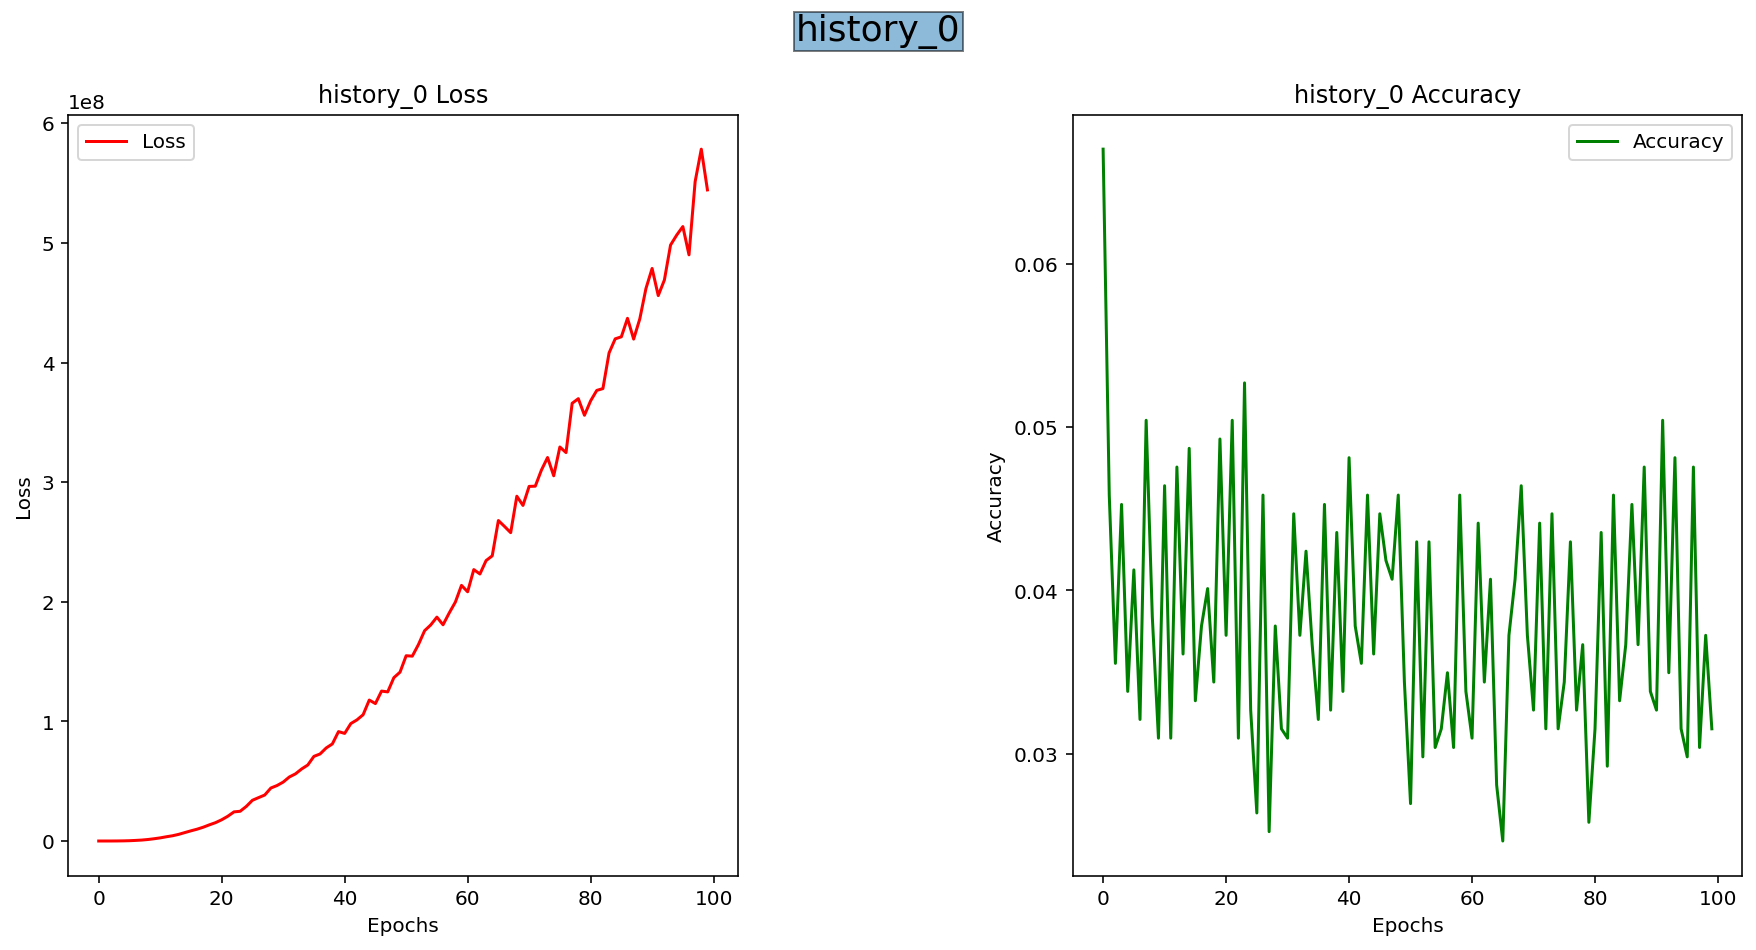

In [ ]:
#run activation
if __name__ == "__main__":
   main_preprocessing()
   print("PREPROCESSING COMPLETE.")

In [ ]:
_refresh_directories()